In [7]:
import numpy as np
from numpy.linalg import inv
import timeit
import cvxpy as cp

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set(rc={'figure.figsize':(14,8.27)}, font_scale=2)
sns.set_palette('colorblind')

# A)

$l_1$: $||$**x**$||_1 = |x_1| + ... + |x_m|$
$l_2$: $||$**x**$||_2 = \sqrt{|x_1|^2 + ... + |x_m|^2}$
$l_\infty$: $||$**x**$||_\infty = max(|x_1| , ... , |x_m|)$

$min_x$$||Ax-b||_1 = min_x \sum_{i=1}^m |  a_{i} x - b_i |$
$min_x$$||Ax-b||_2 = min_x \sqrt{ \sum_{i=1}^m ( a_{i} x - b_i ) ^2 }$
$min_x$$||Ax-b||_ \infty = min_x (max_i|a_i^Tx - b_i|)$

$||Ax-b||_2^2 =  \sum_i^m \left( \sum_j^n a_{ij} x_j - b_i \right) ^2$
produces minimum when gradient is zero w.r.t. $x$.

$\frac{\partial f}{\partial x_p} = 2 \sum_i^m  a_{ip} \sum_j^n ( a_{ij} x_j - b_i ) = 0$  <br/>
$ 2 \sum_i^m  a_{ip} \sum_j^n a_{ij} x_j  = 2 \sum_i^m a_{ip} \sum_j^n  b_i $

in matrix form:
<br/>
$  A^T A x =  A^T b$
$  \rightarrow  x =  (A^T A)^{-1} A^T b$ <br/>

Convex as quadratics only have one minimum

# B)

$min_x$$||Ax-b||_ \infty = min_x (max_i|a_i^Tx - b_i|)$
$min_x$$||Ax-b||_ \infty = min_x (min_t( -t \leq a_i^Tx - b_i \leq t))$
$min_x (min_t( -t \leq a_i^Tx - b_i \leq t)) = min_{x,t} t$
with $-t \leq a_i^Tx - b_i \leq t$ for $i=1,...,m$
This is equivalent to $min_x \tilde{c}^T \tilde{x}$ with constraint $\tilde{A} \tilde{x} \leq \tilde{b}$
Where $$ \tilde{x} =
\left(\begin{array}{cc}
x \\
t
\end{array}\right)
$$
$$ \tilde{c} =
\left(\begin{array}{cc}
0 \\
1
\end{array}\right)
$$
$$ \tilde{A} =
\left(\begin{array}{cc}
A & -1\\
-A & -1
\end{array}\right)
$$
$$ \tilde{b} =
\left(\begin{array}{cc}
b\\
-b
\end{array}\right)
$$

$min_x$$||Ax-b||_1 = min_x \sum_{i=1}^m |  a_{i} x - b_i |$
$min_x$$||Ax-b||_1 = min_x \sum_{i=1}^m min_{t_i}( -t_i \leq a_i^Tx - b_i \leq t_i)$
which is $min_{x,t_i} \sum_{i=1}^m t_i$
with $-t_i \leq a_i^Tx - b_i \leq t_i$ for $i=1,...,m$
This is equivalent to $min_x \tilde{c}^T \tilde{x}$ with constraint $\tilde{A} \tilde{x} \leq \tilde{b}$
Where $$ \tilde{x} =
\left(\begin{array}{cc}
x \\
t
\end{array}\right)
$$
$$ \tilde{c} =
\left(\begin{array}{cc}
0 \\
\textbf{1}
\end{array}\right)
$$
$$ \tilde{A} =
\left(\begin{array}{cc}
A & -\textbf{I}\\
-A & -\textbf{I}
\end{array}\right)
$$
$$ \tilde{b} =
\left(\begin{array}{cc}
b\\
-b
\end{array}\right)
$$

# C)

$min_x \tilde{c}^T \tilde{x}$ subject to $\tilde{A} \tilde{x} \leq \tilde{b}$

Lagragian:
$L(x, \lambda) = \tilde{c}^T \tilde{x} +  \lambda^T (\tilde{A} \tilde{x} - \tilde{b})$
$= - \tilde{b}^T \lambda + (\tilde{A}^T \lambda + \tilde{c})^T \tilde{x}$

Dual Cost:
$min_x L(x, \lambda) = - \tilde{b}^T \lambda$ if $\tilde{A}^T \lambda + \tilde{c} = 0$
or $- \infty$ otherwise

Dual LP problem:
$max_{\lambda}( - \tilde{b}^T \lambda)$ subject to $\tilde{A}^T \lambda + \tilde{c} = 0$ and $\lambda \geq 0$

# D)/E)

In [9]:
Ab = []
for i in range(5):
    A = np.genfromtxt('2023-data/A' + str(i) + '.csv', delimiter=",")
    b = np.genfromtxt('2023-data/b' + str(i) + '.csv', delimiter=",")
    Ab.append((A, b))

In [10]:
def lp(data, norm, method, iterations):
    times = np.zeros(5)
    residuals = [None] * 5
    opt = np.zeros(5)
    low_bound = np.zeros(5)
    for iter in range(iterations):
        for i, (A,b) in enumerate(data):
            m, n = A.shape
            if norm == 'l1':
                x = cp.Variable(n+m)
                c_til = np.zeros((n + m,))
                c_til[-m:] = 1
                b_til = np.hstack((b, -b))
                I = np.identity(m)
                A_til = np.vstack((np.hstack((A, -I)), np.hstack((-A, -I))))
            elif norm == 'linf':
                x = cp.Variable(n+1)
                c_til = np.zeros((n + 1,))
                c_til[-1:] = 1
                b_til = np.hstack((b, -b))
                A_til = np.vstack((np.hstack((A, -np.ones((m, 1)))), np.hstack((-A, -np.ones((m, 1))))))
            else:
                print('Error: incorrect norm')
                return

            start_time = timeit.default_timer()
            prob = cp.Problem(cp.Minimize(c_til.T@x),
                             [A_til @ x <= b_til])
            prob.solve(solver=cp.SCIPY, scipy_options={"method": method})
            time = timeit.default_timer() - start_time

            lam = cp.Variable(2*m)
            dual_prob = cp.Problem(cp.Maximize(-b_til.T@lam),
                             [A_til.T @ lam == -c_til,  lam >= np.zeros((2*m,))])
            dual_prob.solve(solver=cp.SCIPY, scipy_options={"method": method})

            opt[i] = prob.value
            low_bound[i] = dual_prob.value
            residuals[i] = A @ x.value[:n] - b
            times[i] += time / iterations

    return opt, times, residuals, low_bound

## $l_1$ norm

### i) Simplex Method

In [11]:
l1_smp_opt, l1_smp_times, l1_smp_residuals, l1_smp_low = lp(Ab, 'l1', 'highs-ds', 1)

In [12]:
print(l1_smp_opt)
print(l1_smp_low)
print(l1_smp_times)

[  8.64075088  40.47091323 132.38945303 265.56673929 577.27186875]
[  8.64075088  40.47091323 132.38945303 265.56673929 577.27186875]
[1.76748000e-02 8.65886000e-02 5.12834730e+00 4.55921987e+01
 4.50980520e+02]


### ii) Interior Point LP

In [13]:
l1_ipm_opt, l1_ipm_times, l1_ipm_residuals, l1_ipm_low = lp(Ab, 'l1', 'highs-ipm', 1)

In [14]:
print(l1_ipm_opt)
print(l1_ipm_low)
print(l1_ipm_times)

[  8.64075088  40.47091323 132.38945303 265.56673929 577.27186875]
[  8.64075088  40.47091323 132.38945303 265.56673929 577.27186875]
[4.77426000e-02 7.45923000e-02 2.75267310e+00 2.47256156e+01
 1.60988219e+02]


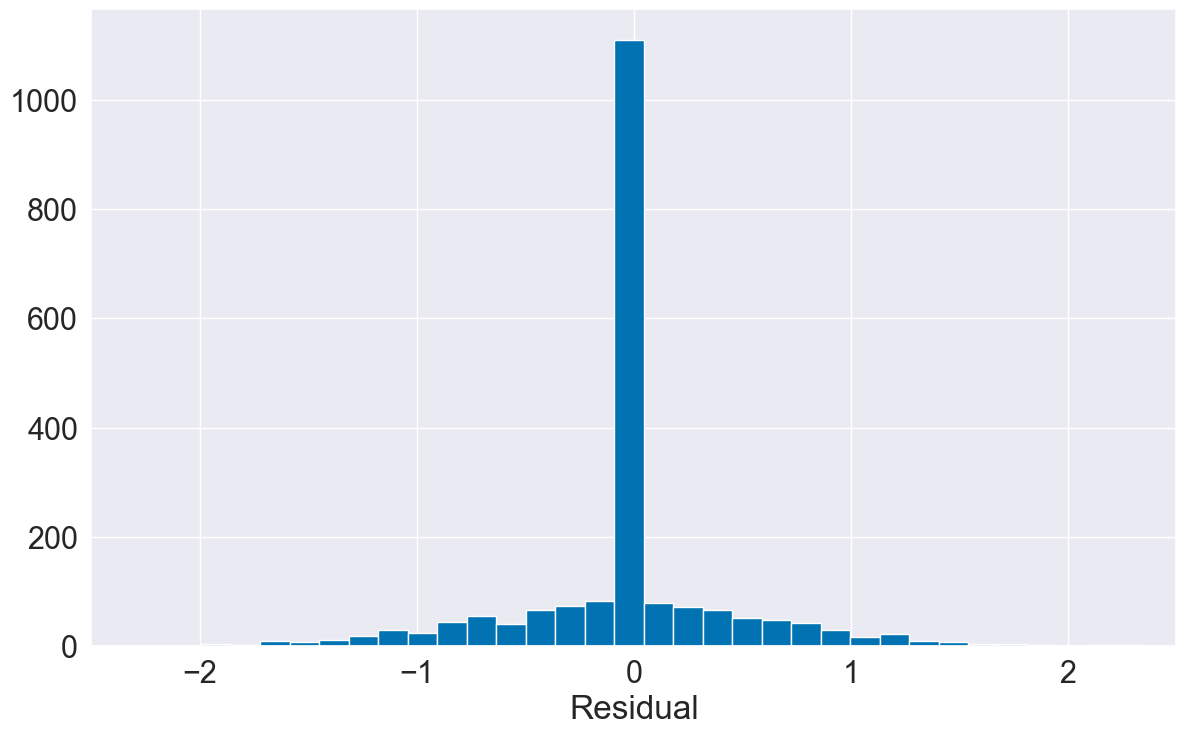

In [24]:
plt.hist(l1_ipm_residuals[-1], bins=40)
plt.xlabel('Residual')
plt.xlim(-2.5,2.5)
plt.savefig('Figures/l1residual.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()

## $l_\infty$ norm

### i) Simplex Method

In [16]:
linf_smp_opt, linf_smp_times, linf_smp_residuals, linf_smp_low = lp(Ab, 'linf', 'highs-ds', 1)

In [17]:
print(linf_smp_opt)
print(linf_smp_low)
print(linf_smp_times)

[0.53190349 0.65544332 0.5786504  0.58076415 0.6024764 ]
[0.53190349 0.65544332 0.5786504  0.58076415 0.6024764 ]
[1.12282000e-02 7.81730000e-02 2.04648740e+00 2.14129171e+01
 5.77470464e+02]


### ii) Interior Point LP

In [18]:
linf_ipm_opt, linf_ipm_times, linf_ipm_residuals, linf_ipm_low = lp(Ab, 'linf', 'highs-ipm', 1)

In [19]:
print(linf_ipm_opt)
print(linf_ipm_low)
print(linf_ipm_times)

[0.53190349 0.65544332 0.5786504  0.58076415 0.6024764 ]
[0.53190349 0.65544332 0.5786504  0.58076415 0.6024764 ]
[1.30444000e-02 6.12975000e-02 1.58294900e+00 9.44308400e+00
 6.30934943e+01]


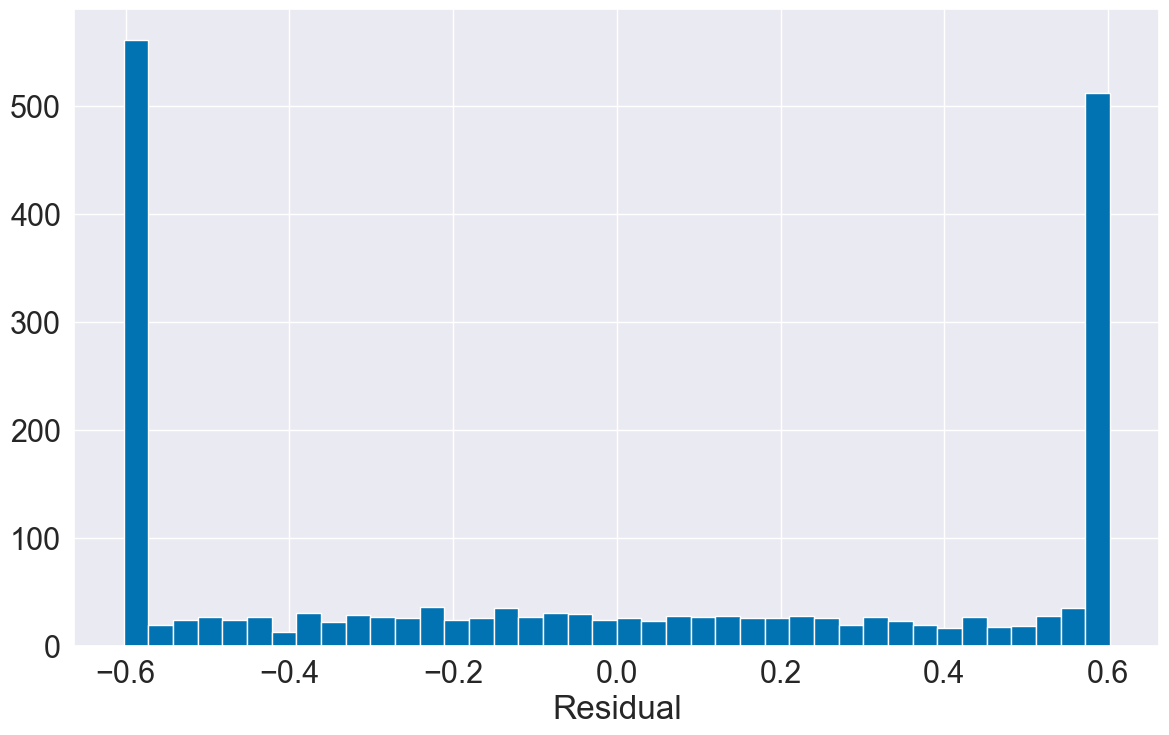

In [20]:
plt.hist(linf_ipm_residuals[-1], bins=40)
plt.xlabel('Residual')
plt.savefig('Figures/linfresidual.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()

## $l_2$ norm

In [21]:
l2_lp_times = [0] * 5
l2_lp_opt = [None] * 5
l2_lp_residuals = [None] * 5
iterations = 10
for n in range(iterations):
    for i, (A,b) in enumerate(Ab):

        start_time = timeit.default_timer()
        x = inv(A.T @ A) @ A.T @ b
        time = timeit.default_timer() - start_time

        l2_lp_residuals[i] = A @ x - b

        l2_lp_opt[i] = np.sqrt(l2_lp_residuals[i].T @ l2_lp_residuals[i])
        l2_lp_times[i] += time / iterations

In [22]:
print(l2_lp_opt)
print(l2_lp_times)

[2.118139329453281, 5.189877332419184, 8.786675092974793, 12.460295288066254, 18.64969450788458]
[0.00036255000304663554, 0.17293789999821457, 1.1226351700010126, 1.7851493499998468, 2.6642757999987223]


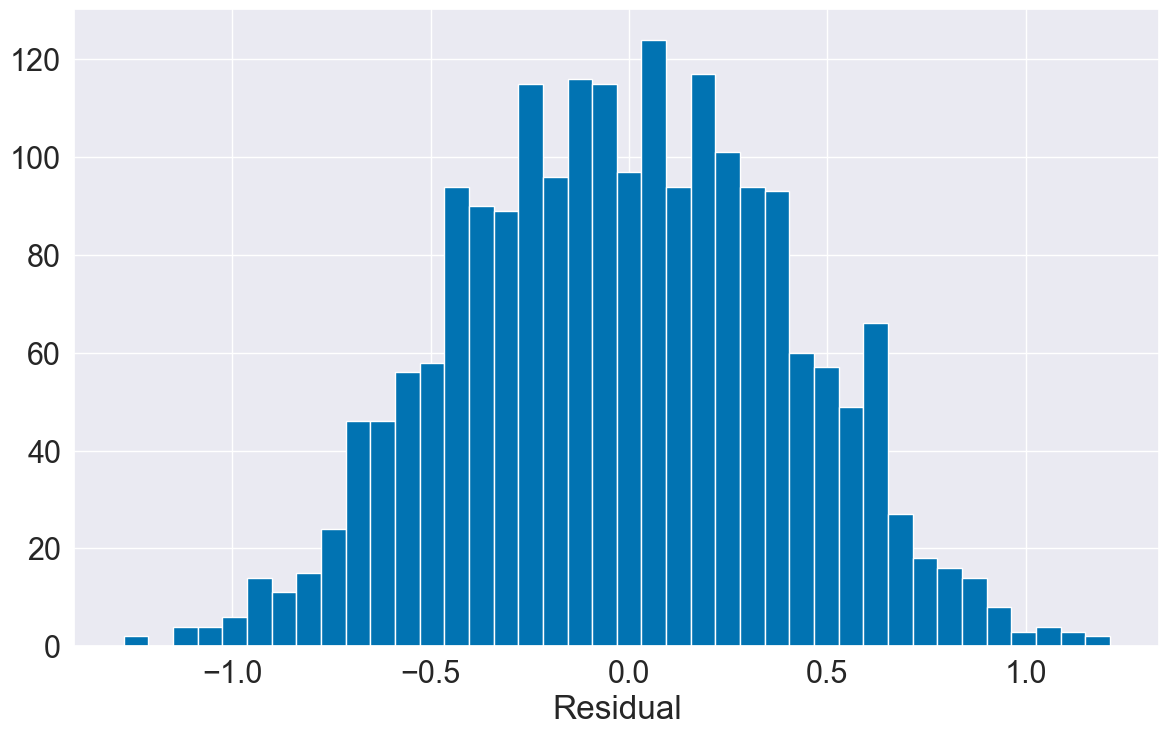

In [23]:
plt.hist(l2_lp_residuals[-1][:], bins=40)
plt.xlabel('Residual')
plt.savefig('Figures/l2residual.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()

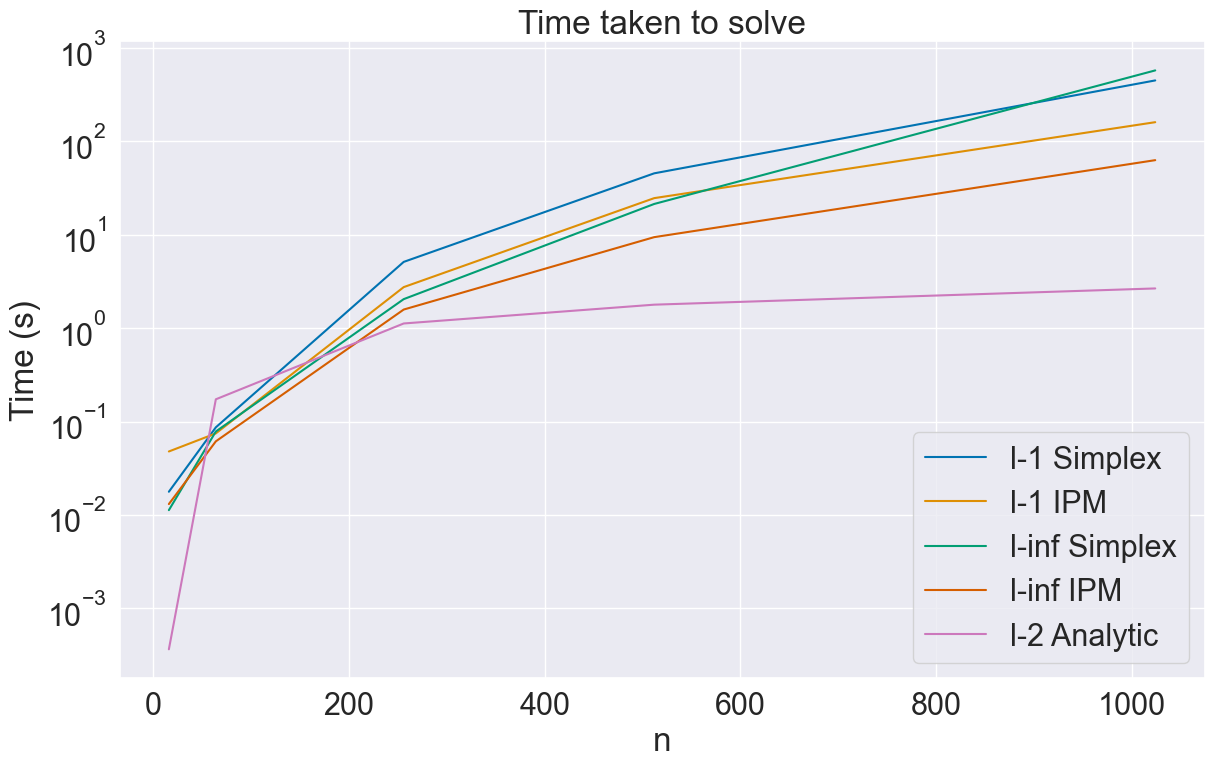

In [49]:
n = np.asarray([16, 64, 256, 512, 1024])
plt.plot(n, l1_smp_times, label="l-1 Simplex")
plt.plot(n, l1_ipm_times, label="l-1 IPM")
plt.plot(n, linf_smp_times, label="l-inf Simplex")
plt.plot(n, linf_ipm_times, label="l-inf IPM")
plt.plot(n, l2_lp_times, label="l-2 Analytic")
plt.title('Time taken to solve')
plt.yscale('log')
plt.legend()
plt.ylabel("Time (s)")
plt.xlabel("n")
plt.savefig('Figures/Ex1_time.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()